In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Create a connection
conn = psycopg2.connect(
    host = "localhost",
    port = 5432, 
    database = "dvdrental",
    user = "postgres",
    password= "nguyenquanghuy25",
)

### EX4: 
- Tìm ra staff có tổng doanh số nhiều nhất trong tháng 3
- Tương tự cho cả năm

In [16]:
query = """
    select * 
    from payment
    limit 5
"""
pd.read_sql(query, conn)

,payment_id,customer_id,staff_id,rental_id,amount,payment_date
0,17503,341,2,1520,7.99,2007-02-15 22:25:46.996577
1,17504,341,1,1778,1.99,2007-02-16 17:23:14.996577
2,17505,341,1,1849,7.99,2007-02-16 22:41:45.996577
3,17506,341,2,2829,2.99,2007-02-19 19:39:56.996577
4,17507,341,2,3130,7.99,2007-02-20 17:31:48.996577


In [18]:
# Tìm staff có doanh số cao nhất trong tháng 3
query = """
    select 
           staff_id,
           SUM(amount) as amount_mar 
    from payment
    where 
        payment_date >= '2007-03-01' 
        and payment_date < '2007-04-01'
    group by staff_id
    order by amount_mar desc
    limit 1
"""
pd.read_sql(query, conn)

,staff_id,amount_mar
0,2,12109.73


#### Tìm STAFF có doanh thu cao nhất theo từng tháng
- CÁCH 1: DÙNG PANDAS

In [31]:
# Đầu tiên xem doanh thu của từng tháng group theo từng nhân viên
query = """
    select 
           date_part('month', payment_date) as pmt_month,
           staff_id,
           SUM(amount) as amount_mar
    from payment
    group by staff_id, pmt_month
    order by pmt_month, staff_id
"""
df = pd.read_sql(query, conn)
df

,pmt_month,staff_id,amount_mar
0,2.0,1,4160.84
1,2.0,2,4191.00
2,3.0,1,11776.83
3,3.0,2,12109.73
4,4.0,1,14080.36
5,4.0,2,14479.10
6,5.0,1,234.09
7,5.0,2,280.09


In [24]:
# Xem dữ liệu có bao nhiêu năm 
q = """
    select distinct
        date_part('year', payment_date) as payment_year
    from payment
"""
pd.read_sql(q, conn)

,payment_year
0,2007.0


In [29]:
# Chuyển đổi dữ liệu từ long data sang wise data
df2 = df.pivot(
    index = "pmt_month", 
    columns = "staff_id", 
    values = "amount_mar"
)
df2.head()

staff_id,1,2
pmt_month,,
2.0,4160.84,4191.00
3.0,11776.83,12109.73
4.0,14080.36,14479.10
5.0,234.09,280.09


In [33]:
df2["max_value"] = df2.max(axis =1)
df2

staff_id,1,2,max_value
pmt_month,,,
2.0,4160.84,4191.00,4191.00
3.0,11776.83,12109.73,12109.73
4.0,14080.36,14479.10,14479.10
5.0,234.09,280.09,280.09


- CÁCH 2: DÙNG SQL -> WINDOW FUNCTION

In [36]:
# Ta xem đoạn select là một table để có thể truy vấn vào table đó 
# và ta kẹp điều kiện là lấy theo rank =1 
query = """
select * 
from (
    select 
           date_part('month', payment_date) as pmt_month,
           staff_id,
           SUM(amount) as total_amount,
           rank() over (partition by date_part('month', payment_date) order by SUM(amount) desc)
    from payment
    group by staff_id, pmt_month
    order by pmt_month, rank
) as temp
where rank=1
"""
df = pd.read_sql(query, conn)
df

,pmt_month,staff_id,total_amount,rank
0,2.0,2,4191.00,1
1,3.0,2,12109.73,1
2,4.0,2,14479.10,1
3,5.0,2,280.09,1


### EX5:
- Tính tổng số phim có mỗi category
- Plot

In [3]:
q = """
    select 
        category_id,
        Count(*) as n_films
    from film_category
    group by category_id
    order by category_id
"""
df = pd.read_sql(q, conn)
df.head(3)


,category_id,n_films
0,1,64
1,2,66
2,3,60


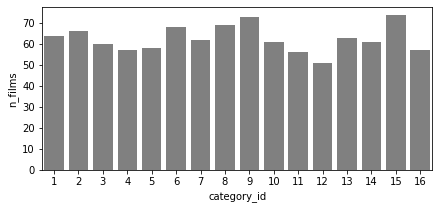

In [16]:
fig, ax = plt.subplots(figsize = (7,3))
sns.barplot(
    x = "category_id",
    y = "n_films",
    color = "grey",
    ax = ax,
    data = df
)
plt.show()

## 2. Join
### Ex1: 
- Lấy ra title, langue_id, language Name, rating cho các bộ phim có rating là `R`
- Có phim nào không có thông tin languege Name

In [22]:
# Lấy ra title, langue_id, language Name, rating cho các bộ phim có rating là R
q = """
    select 
        title, 
        film.language_id, 
        name,
        rating
    from film inner join language on film.language_id = language.language_id
    where rating ='R'
"""
pd.read_sql(q, conn)

,title,language_id,name,rating
0,Grosse Wonderful,1,English,R
1,Airport Pollock,1,English,R
2,Date Speed,1,English,R
3,Alone Trip,1,English,R
4,Amelie Hellfighters,1,English,R
...,...,...,...,...
190,Women Dorado,1,English,R
191,Worker Tarzan,1,English,R
192,Working Microcosmos,1,English,R
193,Yentl Idaho,1,English,R


In [27]:
# Có phim nào không có thông tin languege Name
q = """
    select 
        title, 
        film.language_id, 
        name as language,
        rating
    from film inner join language on film.language_id = language.language_id
    where name is null
"""
pd.read_sql(q, conn)

,title,language_id,language,rating


### Ex2: 
- Lấy ra title, category ID, category Name, rating cho các bộ phim có rating là `R`
- Có phim nào không có thông tin category name không?

In [32]:
# Lấy ra title, category ID, category Name, rating cho các bộ phim có rating là R
q = """
    select 
        title,
        film_category.category_id,
        name as category,
        rating
    from film inner join film_category on film.film_id = film_category.film_id 
              inner join category on film_category.category_id = category.category_id
    where rating = 'R' 
"""
pd.read_sql(q, conn)

,title,category_id,category,rating
0,Airport Pollock,11,Horror,R
1,Alone Trip,12,Music,R
2,Amelie Hellfighters,12,Music,R
3,American Circus,1,Action,R
4,Anaconda Confessions,2,Animation,R
...,...,...,...,...
190,Women Dorado,1,Action,R
191,Worker Tarzan,16,Travel,R
192,Working Microcosmos,16,Travel,R
193,Yentl Idaho,11,Horror,R


In [31]:
# Có phim nào không có thông tin category name không?
q = """
    select 
        title,
        film_category.category_id,
        name as category,
        rating
    from film inner join film_category on film.film_id = film_category.film_id 
              inner join category on film_category.category_id = category.category_id
    where name is null 
"""
pd.read_sql(q, conn)

,title,category_id,category,rating


### Ex3: 
- Lấy ra title, film ID, actor ID, acctor fullname cho các bộ phim có rating là `R`


In [38]:
q = """
    select 
        title,
        a.film_id,
        (c.first_name || ' ' || c.last_name) as full_name
    from film as a 
                  inner join film_actor as b 
                      on a.film_id = b.film_id
                  inner join actor as c
                      on b.actor_id = c.actor_id
    where rating = 'R'
"""
pd.read_sql(q,conn)

,title,film_id,full_name
0,Anaconda Confessions,23,Penelope Guiness
1,Rules Human,749,Penelope Guiness
2,Vertigo Northwest,939,Penelope Guiness
3,Fight Jawbreaker,314,Nick Wahlberg
4,Roof Champion,742,Nick Wahlberg
...,...,...,...
1026,Candidate Perdition,116,Thora Temple
1027,Galaxy Sweethearts,346,Thora Temple
1028,Interview Liaisons,465,Thora Temple
1029,Madison Trap,544,Thora Temple


- Tìm xem một diễn viên đã đóng bao nhiêu bộ phim 

In [56]:
q = """
       select 
         c.actor_id,
        (c.first_name || ' ' || c.last_name) as full_name,
        count(*) as n_flim
    from film as a 
                  inner join film_actor as b 
                      on a.film_id = b.film_id
                  inner join actor as c
                      on b.actor_id = c.actor_id
    group by c.actor_id, (c.first_name || ' ' || c.last_name)
    order by n_flim desc
    limit 5
"""
pd.read_sql(q, conn)

,actor_id,full_name,n_flim
0,107,Gina Degeneres,42
1,102,Walter Torn,41
2,198,Mary Keitel,40
3,181,Matthew Carrey,39
4,23,Sandra Kilmer,37


## EX4:
- Lấy thông tin khách hàng gồm: id, names, email, phone, address(full)

In [12]:
# Lấy thông tin khách hàng gồm: id, names, email, phone, address(full)
q = """
    select 
        customer_id,
        (customer.first_name || ' ' || customer.last_name) as fullname,
        email,
        phone,
        (address || '' || address2) as address,
        city,
        country
    from customer left join address on customer.address_id = address.address_id
                  left join city on address.city_id = city.city_id
                  left join country on city.country_id = country.country_id
    limit 10
"""
pd.read_sql(q,conn)

,customer_id,fullname,email,phone,address,city,country
0,1,Mary Smith,mary.smith@sakilacustomer.org,28303384290,1913 Hanoi Way,Sasebo,Japan
1,2,Patricia Johnson,patricia.johnson@sakilacustomer.org,838635286649,1121 Loja Avenue,San Bernardino,United States
2,3,Linda Williams,linda.williams@sakilacustomer.org,448477190408,692 Joliet Street,Athenai,Greece
3,4,Barbara Jones,barbara.jones@sakilacustomer.org,705814003527,1566 Inegl Manor,Myingyan,Myanmar
4,5,Elizabeth Brown,elizabeth.brown@sakilacustomer.org,10655648674,53 Idfu Parkway,Nantou,Taiwan
5,6,Jennifer Davis,jennifer.davis@sakilacustomer.org,860452626434,1795 Santiago de Compostela Way,Laredo,United States
6,7,Maria Miller,maria.miller@sakilacustomer.org,716571220373,900 Santiago de Compostela Parkway,Kragujevac,Yugoslavia
7,8,Susan Wilson,susan.wilson@sakilacustomer.org,657282285970,478 Joliet Way,Hamilton,New Zealand
8,9,Margaret Moore,margaret.moore@sakilacustomer.org,380657522649,613 Korolev Drive,Masqat,Oman
9,10,Dorothy Taylor,dorothy.taylor@sakilacustomer.org,648856936185,1531 Sal Drive,Esfahan,Iran


In [18]:
# Nước nào có nhiều customer nhất
q = """
    select 
        country,
        count(*) as n_country
    from customer left join address on customer.address_id = address.address_id
                  left join city on address.city_id = city.city_id
                  left join country on city.country_id = country.country_id
    group by country
    order by n_country desc
    limit 1
"""
pd.read_sql(q,conn)

,country,n_country
0,India,60
